# MeanShift with MinMaxScaler

This Code template is for the Cluster analysis using a simple Mean Shift(Centroid-Based Clustering using a flat kernel) Clustering algorithm along with feature scaling using MinMaxScaler and includes 2D and 3D cluster visualization of the Clusters.

### Required Packages

In [ ]:
!pip install plotly

In [2]:
import operator
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from sklearn.cluster import MeanShift, estimate_bandwidth
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [5]:
file_path = ""

List of features which are required for model training

In [3]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df=pd.read_csv(file_path)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [9]:
X = df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [7]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.

In [10]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
X.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### Data Rescaling

`MinMaxScaler` subtracts the minimum value in the feature and then divides by the range, where range is the difference between the original maximum and original minimum.

[For more Reference](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Model

Mean shift clustering using a flat kernel.

Mean shift clustering aims to discover â€œblobsâ€ in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

Seeding is performed using a binning technique for scalability.
[More information](https://analyticsindiamag.com/hands-on-tutorial-on-mean-shift-clustering-algorithm/)

#### Tuning Parameters

    1. bandwidthfloat, default=None
> Bandwidth used in the RBF kernel.
If not given, the bandwidth is estimated using sklearn.cluster.estimate_bandwidth

    2. seedsarray-like of shape (n_samples, n_features), default=None
> Seeds used to initialize kernels. If not set, the seeds are calculated by clustering.get_bin_seeds with bandwidth as the grid size and default values for other parameters.

    3. bin_seedingbool, default=False
> If true, initial kernel locations are not locations of all points, but rather the location of the discretized version of points, where points are binned onto a grid whose coarseness corresponds to the bandwidth. 

    4. min_bin_freqint, default=1
> To speed up the algorithm, accept only those bins with at least min_bin_freq points as seeds.

    5. cluster_allbool, default=True
> If true, then all points are clustered, even those orphans that are not within any kernel. Orphans are assigned to the nearest kernel. If false, then orphans are given cluster label -1

    6. n_jobsint, default=None
> The number of jobs to use for the computation. This works by computing each of the n_init runs in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

    7. max_iterint, default=300
> Maximum number of iterations, per seed point before the clustering operation terminates

[For more detail on API](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)
<br> 
<br>
#### Estimate Bandwidth 
Estimate the bandwidth to use with the mean-shift algorithm.

That this function takes time at least quadratic in n_samples. For large datasets, itâ€™s wise to set that parameter to a small value.

In [12]:
bandwidth = estimate_bandwidth(X_scaled, quantile=0.15)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)
y_pred = ms.predict(X_scaled)

### Cluster Analysis

First, we add the cluster labels from the trained model into the copy of the data frame for cluster analysis/visualization.

In [13]:
ClusterDF = X.copy()
ClusterDF['ClusterID'] = y_pred
ClusterDF.head()

,Age,Annual Income (k$),Spending Score (1-100),ClusterID
0,19,15,39,0
1,21,15,81,0
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


#### Cluster Records
The below bar graphs show the number of data points in each available cluster.

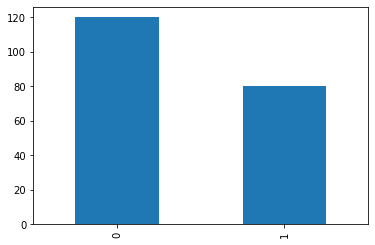

In [14]:
ClusterDF['ClusterID'].value_counts().plot(kind='bar')

#### Cluster Plots
Below written functions get utilized to plot 2-Dimensional and 3-Dimensional cluster plots on the available set of features in the dataset. Plots include different available clusters along with cluster centroid.

In [15]:
def Plot2DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 2)):
        plt.rcParams["figure.figsize"] = (8,6)
        xi,yi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1])
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            plt.scatter(DFC[i[0]],DFC[i[1]],cmap=plt.cm.Accent,label=j)
        plt.scatter(ms.cluster_centers_[:,xi],ms.cluster_centers_[:,yi],marker="^",color="black",label="centroid")
        plt.xlabel(i[0])
        plt.ylabel(i[1])
        plt.legend()
        plt.show()

def Plot3DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig,ax = plt.figure(figsize = (16, 10)),plt.axes(projection ="3d")
        ax.grid(b = True, color ='grey',linestyle ='-.',linewidth = 0.3,alpha = 0.2)
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            ax.scatter3D(DFC[i[0]],DFC[i[1]],DFC[i[2]],alpha = 0.8,cmap=plt.cm.Accent,label=j)
        ax.scatter3D(ms.cluster_centers_[:,xi],ms.cluster_centers_[:,yi],ms.cluster_centers_[:,zi],
                     marker="^",color="black",label="centroid")
        ax.set_xlabel(i[0])
        ax.set_ylabel(i[1])
        ax.set_zlabel(i[2])
        plt.legend()
        plt.show()
    
def Plotly3D(X_Cols,df):
    for i in list(itertools.combinations(X_Cols,3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig1 = px.scatter_3d(ms.cluster_centers_,x=ms.cluster_centers_[:,xi],y=ms.cluster_centers_[:,yi],
                             z=ms.cluster_centers_[:,zi])
        fig2=px.scatter_3d(df, x=i[0], y=i[1],z=i[2],color=df['ClusterID'])
        fig3 = go.Figure(data=fig1.data + fig2.data,
                         layout=go.Layout(title=go.layout.Title(text="x:{}, y:{}, z:{}".format(i[0],i[1],i[2])))
                        )
        fig3.show()

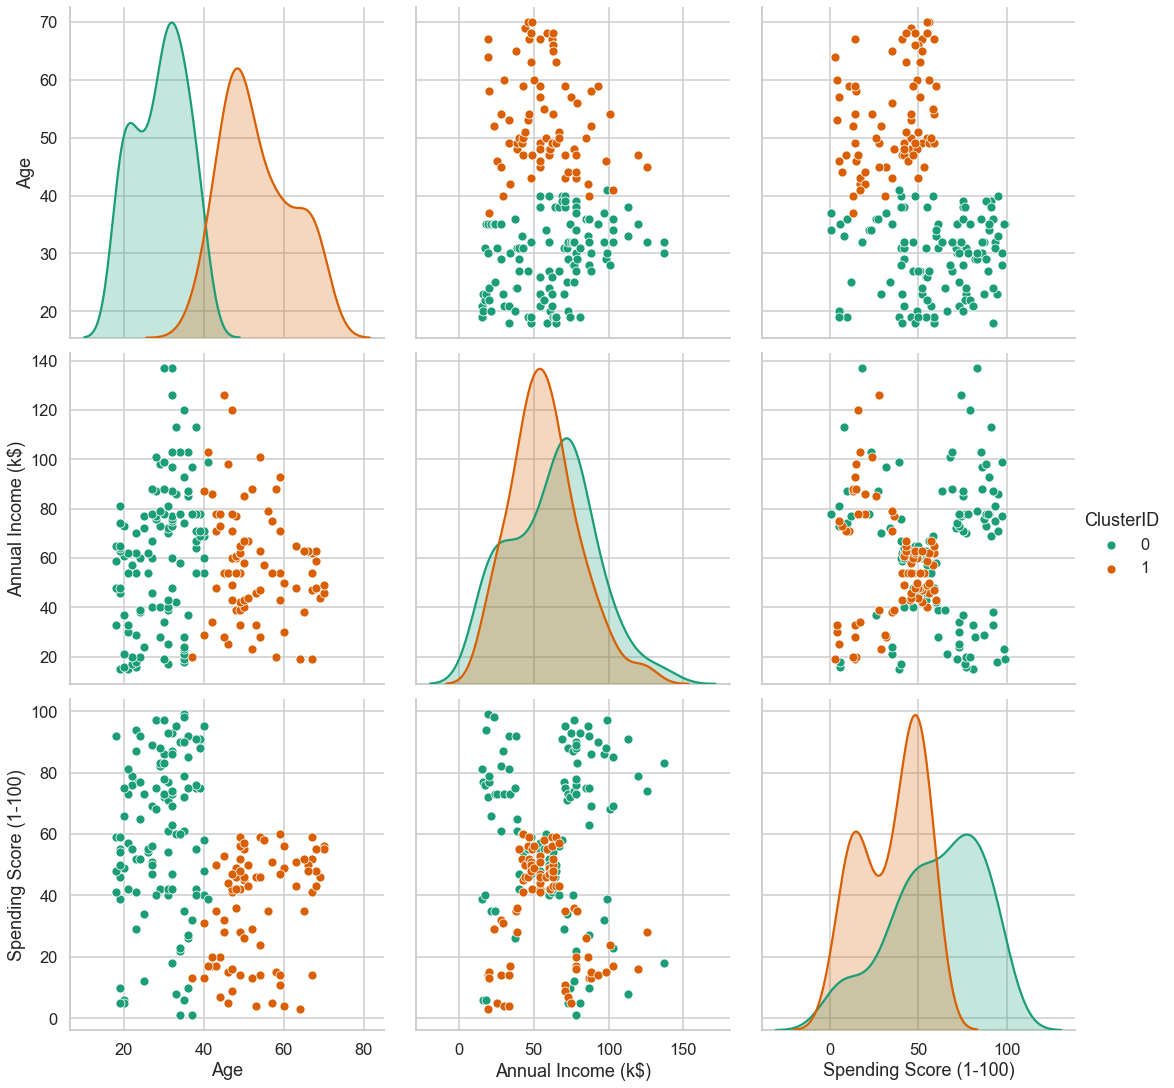

In [16]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["lines.markeredgewidth"] = 1
sns.pairplot(data=ClusterDF, hue='ClusterID', palette='Dark2', height=5)

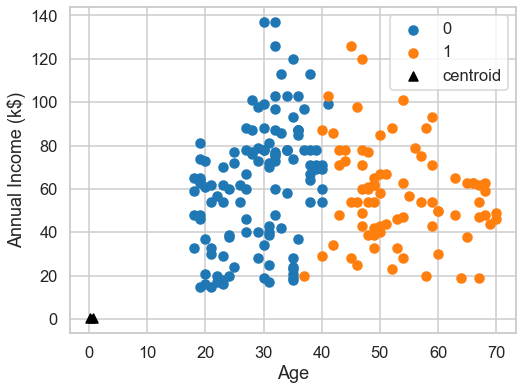

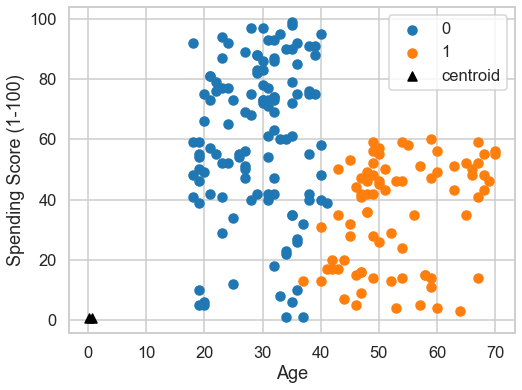

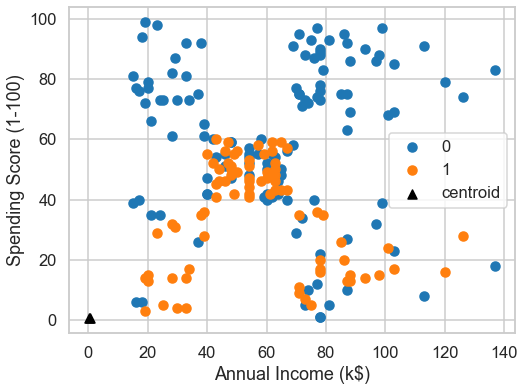

In [17]:
Plot2DCluster(X.columns,ClusterDF)

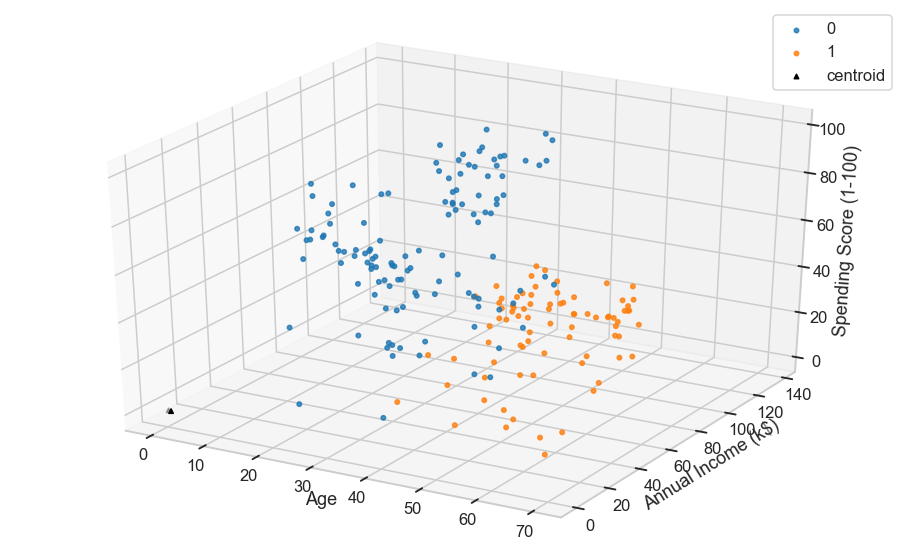

In [18]:
Plot3DCluster(X.columns,ClusterDF)

In [19]:
Plotly3D(X.columns,ClusterDF)

#### Creator: Vamsi Mukkamala , Github: [Profile](https://github.com/vmc99)